In [1]:
%matplotlib inline

import os
import tqdm
import json

import catboost
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import reload
import common
reload(common)
from common import (plot_features_target_correlation, plot_learning_curve, join_dataframes, 
                    get_sorted_factors, calculate_eval_metrics, plot_feature_importance, 
                    get_technical_indicators_df, plot_eval_metrics)

# SP 500 symbols

In [2]:
with open('../sp_500_symbols.txt', 'r') as f:
    sp_500_symbols = f.read().split('\n')[:-1]
    
len(sp_500_symbols)

505

# Data

In [3]:
tech_ind_dir = '/home/artem/Documents/ML-DS/AlgorithmicTrading/tech_ind_data_202012'
time_ser_dir = '/home/artem/Documents/ML-DS/AlgorithmicTrading/time_series_data_202012'

In [4]:
def read_df(tech_ind_dir_path, time_ser_dir_path, tech_ind_postfix, time_ser_postfix, symbols):
    df = pd.DataFrame()
    for s in tqdm.tqdm(symbols):

        cur_tech_ind_df_path = os.path.join(tech_ind_dir_path, s + tech_ind_postfix)
        cur_time_ser_df_path = os.path.join(time_ser_dir_path, s + time_ser_postfix)
        
        if not os.path.exists(cur_tech_ind_df_path):
            print('No tech indices for {}'.format(s))
            continue
        if not os.path.exists(cur_time_ser_df_path):
            print('No time series for {}'.format(s))
            continue
            
        cur_tech_ind_df = pd.read_csv(cur_tech_ind_df_path)
        cur_time_ser_df = pd.read_csv(cur_time_ser_df_path)
        
        joined_df = cur_tech_ind_df.join(cur_time_ser_df.set_index('date'), on='date', how='inner')
        
        joined_df_w_next_close = joined_df[:-1].copy()
        joined_df_w_next_close['next_close'] = joined_df['close'][1:].values
        
        df = df.append(joined_df_w_next_close, ignore_index=True, sort=False)
    
    return df

In [5]:
df = read_df(tech_ind_dir, time_ser_dir, '_tech_ind.csv', '_time_series.csv', sp_500_symbols)
df

 17%|█▋        | 86/505 [00:05<00:26, 15.72it/s]

No tech indices for BF.B


 19%|█▉        | 98/505 [00:06<00:21, 18.69it/s]

No tech indices for CBS


100%|██████████| 505/505 [00:36<00:00, 18.10it/s]


,date,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,...,bbands_14_low,bbands_7_mid,bbands_7_up,bbands_7_low,open,high,low,close,volume,next_close
0,2020-08-04,152.6441,153.4986,153.4279,0.7861,-7.9392,-7.2023,34.7561,41.6892,14.2289,...,146.0073,151.4611,159.8882,143.0340,149.90,151.2400,149.6600,151.21,1848626.0,155.35
1,2020-08-05,152.2139,153.1600,153.4196,4.0679,-4.4118,-3.9106,51.9126,49.5869,15.5927,...,145.9399,150.3536,154.9682,145.7390,152.16,155.4000,152.1000,155.35,2723360.0,156.00
2,2020-08-06,151.7947,153.1320,153.4200,0.6387,-7.1138,-4.4216,54.1223,50.7156,24.7066,...,145.9428,150.4477,155.2658,145.6295,155.93,156.4900,154.6800,156.00,2885798.0,158.33
3,2020-08-07,151.2587,153.1721,153.5296,2.2894,2.9477,-1.4739,61.5178,54.6362,38.1116,...,145.9768,150.7396,156.4364,145.0428,155.99,158.4200,155.0700,158.33,2184531.0,161.44
4,2020-08-10,151.9257,153.3784,153.6959,3.0558,5.0996,4.9817,69.2395,59.2912,52.4387,...,145.7720,152.0478,159.8089,144.2868,158.55,161.6000,158.5500,161.44,2272795.0,163.38
5,2020-08-11,152.7041,153.6876,153.8954,1.9062,11.0638,5.4828,73.1590,61.9165,66.0995,...,145.3740,153.8600,162.7009,145.0191,164.13,166.6400,163.0400,163.38,3764883.0,164.26
6,2020-08-12,154.0295,154.0216,154.2522,0.8647,13.5497,5.4533,74.8546,63.0796,76.7005,...,144.9558,155.8041,164.4325,147.1756,165.00,165.9500,163.3500,164.26,2079670.0,165.86
7,2020-08-13,155.7097,154.2197,154.6784,1.5721,15.1808,6.4555,77.8260,65.1629,83.1698,...,144.4154,157.8605,165.4113,150.3096,165.52,167.4900,164.7500,165.86,2884061.0,166.10
8,2020-08-14,157.4227,155.0337,155.2321,0.2358,14.6305,6.1509,78.2753,65.4775,87.2494,...,144.0786,159.3694,166.3464,152.3924,164.61,166.3000,164.5200,166.10,1607354.0,164.71
9,2020-08-17,158.8965,155.6731,155.6803,-1.3658,9.1969,1.4444,68.8498,61.9854,88.7925,...,144.2495,160.5920,165.5930,155.5911,165.17,166.3700,163.6500,164.71,2065541.0,164.38


# Inspect data

In [6]:
df.shape

(49005, 35)

In [7]:
df.columns

Index(['date', 'sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15',
       'rsi_7', 'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7',
       'adx_14', 'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7',
       'mfi_14', 'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid',
       'bbands_14_low', 'bbands_7_mid', 'bbands_7_up', 'bbands_7_low', 'open',
       'high', 'low', 'close', 'volume', 'next_close'],
      dtype='object')

In [8]:
df.sort_values(by='date', inplace=True)

In [9]:
dates, symbols_cnt = df.date.unique(), df.groupby('date').date.count().values

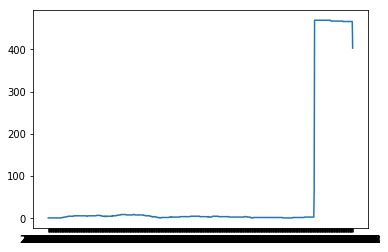

In [10]:
plt.plot(dates, symbols_cnt)

In [11]:
symbols_cnt

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,
         2,   3,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   5,   5,   5,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   7,
         7,   7,   7,   7,   6,   6,   6,   6,   6,   5,   5,   5,   5,
         5,   5,   4,   5,   5,   5,   5,   4,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   6,   5,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   

In [12]:
df[['close', 'next_close']].head()

,close,next_close
12177,29.56,29.03
12178,29.03,28.82
12179,28.82,28.54
12180,28.54,28.03
12181,28.03,27.54


In [13]:
min_date = df.groupby('date').date.count()[df.groupby('date').date.count() > 66].index.min()
min_date

'2020-08-05'

# Prepare training data

In [14]:
df_filtered = df[df.date > min_date]

In [15]:
df_filtered.shape

(45759, 35)

In [16]:
df_train = df_filtered.drop(['date', 'next_close'], axis=1).copy()
df_train['target'] = (df_filtered['next_close'] - df_filtered['close']) / df_filtered['close']

# Analyze trainig data

In [17]:
df_train['target'].mean()

0.0017614354999478249

In [18]:
df_train.columns

Index(['sma_9', 'sma_13', 'sma_26', 'mom_1', 'mom_8', 'mom_15', 'rsi_7',
       'rsi_14', 'slowd', 'slowk', 'dema_13', 'dema_26', 'adx_7', 'adx_14',
       'cci_7', 'cci_14', 'aroon_up', 'aroon_down', 'mfi_7', 'mfi_14',
       'chaikin_a/d', 'obv', 'bbands_14_up', 'bbands_14_mid', 'bbands_14_low',
       'bbands_7_mid', 'bbands_7_up', 'bbands_7_low', 'open', 'high', 'low',
       'close', 'volume', 'target'],
      dtype='object')

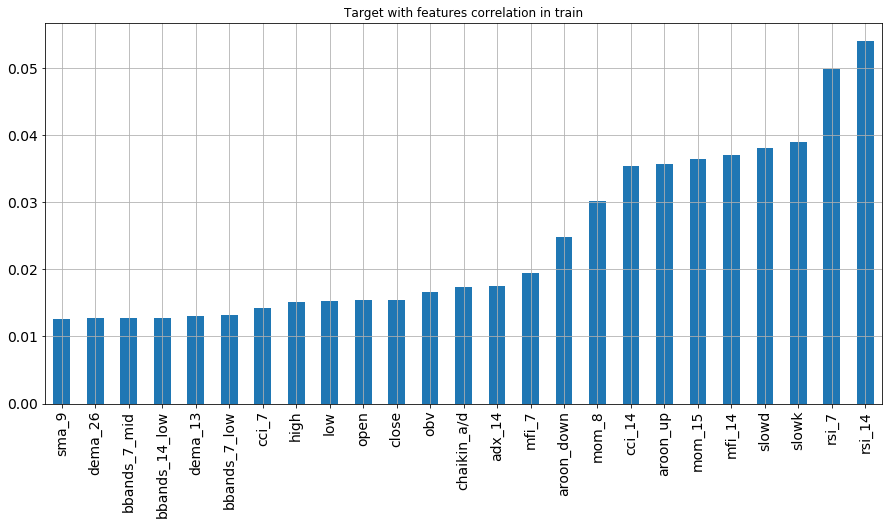

In [19]:
plot_features_target_correlation(df_train, 'train', 'target')

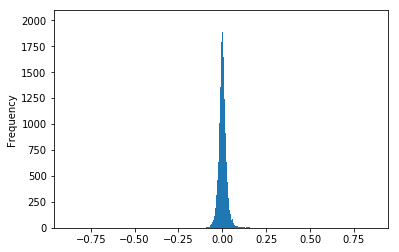

In [20]:
df_train['target'].plot(kind='hist', bins=1000)

# Train model

In [21]:
def prepare_train_test(df, train_fr=0.9, should_print=True):
    train_data_size = int(len(df) * train_fr)
    if should_print:
        print('Train size: {} | Test size: {}'.format(train_data_size, len(df) - train_data_size))
    df_shuffled = df.sample(frac=1)
    
    train = df_shuffled[:train_data_size]
    test = df_shuffled[train_data_size:].copy()
    return train, test

In [22]:
train, test = prepare_train_test(df_train)
train.head()

Train size: 41183 | Test size: 4576


,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,slowk,...,bbands_14_low,bbands_7_mid,bbands_7_up,bbands_7_low,open,high,low,close,volume,target
16550,211.9271,211.8938,204.3092,6.9699,10.0765,23.3194,73.9231,69.1591,92.5756,95.4780,...,200.5262,211.9118,226.8193,197.0043,216.20,223.540,216.2000,222.93,1373173.0,-0.005428
17509,163.9967,162.6769,154.6077,3.5200,3.8700,8.9500,68.3780,68.8589,73.6334,76.8066,...,157.6311,164.1329,166.3518,161.9140,162.67,166.320,162.0700,166.07,412515.0,0.015054
28218,88.2961,87.9965,88.7867,3.3500,9.9900,8.6500,79.4621,64.4438,77.1774,93.3216,...,80.9332,88.8593,98.3898,79.3288,94.25,98.125,93.2957,97.13,5863849.0,-0.001235
37841,596.8878,599.9723,610.4250,-18.4700,-50.1100,-58.8400,30.3719,36.3063,15.7067,8.5753,...,566.0457,592.1457,629.7729,554.5186,577.78,578.990,560.7800,561.89,688659.0,0.016480
38080,90.1733,90.7215,92.0442,1.4700,1.0000,0.4200,67.2451,57.9006,46.7435,66.3334,...,86.5400,89.6900,94.5511,84.8289,92.78,95.870,92.7800,93.87,1664857.0,0.017471


In [23]:
extract_target = lambda df: df.target.apply(lambda x: 1 if x > 0 else 0)
extract_weight = lambda df: df.target.apply(lambda x: 1 + abs(x * 100))

train_x = train.drop(['target'], axis=1)
train_y = extract_target(train)
train_w = extract_weight(train)

test_x = test.drop(['target'], axis=1)
test_y = extract_target(test)
test_w = extract_weight(test)

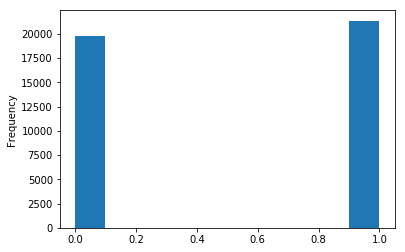

In [24]:
train_y.plot(kind='hist')

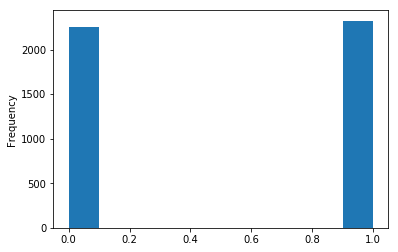

In [25]:
test_y.plot(kind='hist')

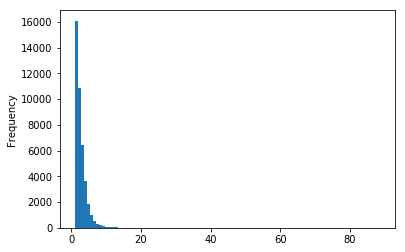

In [26]:
train_w.plot(kind='hist', bins=100)

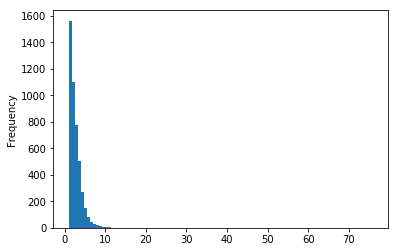

In [27]:
test_w.plot(kind='hist', bins=100)

In [28]:
classifier = CatBoostClassifier(
    iterations=5000, 
    learning_rate=0.02,
    depth=6,
#     l2_leaf_reg=1,
    loss_function='Logloss',
    eval_metric='Precision',
#     border_count=32,
#     leaf_estimation_iterations=10,
#     leaf_estimation_method='Newton',
    use_best_model=True,
    task_type='CPU'
)
classifier.fit(
    train_x,
    train_y,
    sample_weight=train_w,
    eval_set=Pool(test_x, test_y, weight=test_w),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

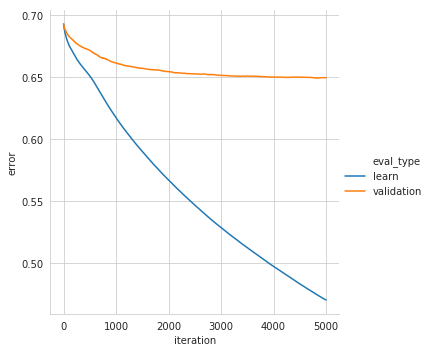

In [29]:
plot_learning_curve(classifier, 'Logloss')

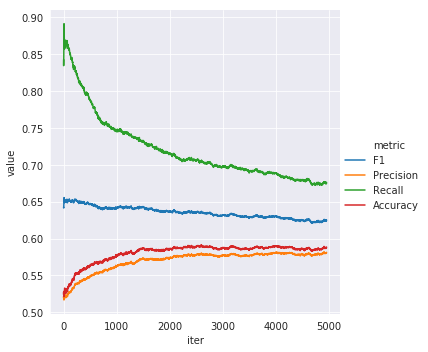

In [30]:
plot_eval_metrics(classifier, test_x, test_y, ['F1', 'Precision', 'Recall', 'Accuracy'])

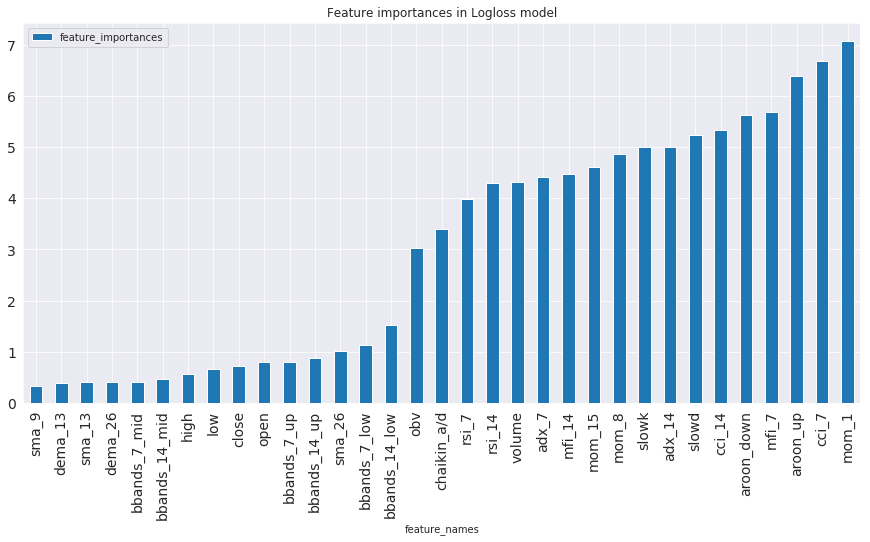

In [31]:
plot_feature_importance(classifier, 'Logloss', 40)

In [32]:
preds = classifier.predict_proba(test_x)

(array([  3.,   3.,   3.,   4.,   6.,   5.,  15.,  17.,  22.,  38.,  42.,
         53.,  65.,  94., 112., 152., 154., 214., 182., 253., 266., 287.,
        292., 280., 284., 281., 227., 220., 190., 171., 137., 124.,  97.,
         83.,  62.,  39.,  45.,  17.,  15.,  13.,   3.,   4.,   2.]),
 array([0.04016533, 0.06149434, 0.08282334, 0.10415235, 0.12548135,
        0.14681036, 0.16813936, 0.18946837, 0.21079738, 0.23212638,
        0.25345539, 0.27478439, 0.2961134 , 0.31744241, 0.33877141,
        0.36010042, 0.38142942, 0.40275843, 0.42408743, 0.44541644,
        0.46674545, 0.48807445, 0.50940346, 0.53073246, 0.55206147,
        0.57339047, 0.59471948, 0.61604849, 0.63737749, 0.6587065 ,
        0.6800355 , 0.70136451, 0.72269352, 0.74402252, 0.76535153,
        0.78668053, 0.80800954, 0.82933854, 0.85066755, 0.87199656,
        0.89332556, 0.91465457, 0.93598357, 0.95731258]),
 <a list of 43 Patch objects>)

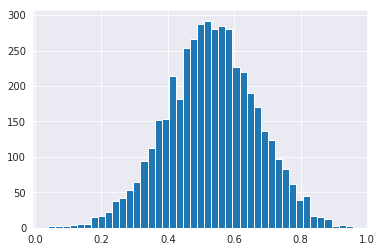

In [33]:
plt.hist(preds[:, 1], bins='auto')

In [34]:
test['pred'] = preds[:, 1]

In [35]:
test.head()

,sma_9,sma_13,sma_26,mom_1,mom_8,mom_15,rsi_7,rsi_14,slowd,slowk,...,bbands_7_mid,bbands_7_up,bbands_7_low,open,high,low,close,volume,target,pred
40319,159.7267,159.7491,158.7529,1.7633,-2.2813,1.5375,48.5661,52.0429,18.7604,22.3813,...,158.8766,165.2303,152.5229,157.37,160.430,156.8100,159.01,648202.0,0.021005,0.611694
6765,106.1956,106.1841,108.7414,1.6510,0.7913,-2.7018,52.7173,52.8681,32.7503,35.7388,...,106.2161,108.1283,104.3038,106.41,108.250,105.9050,107.63,1678534.0,-0.010592,0.609047
35954,42.7753,43.1207,43.0117,-0.0098,0.5562,0.0098,53.0910,52.4309,35.9303,35.4043,...,42.8055,44.1554,41.4556,44.71,44.720,43.7481,44.33,964266.0,-0.050079,0.485072
24556,27.7187,27.3856,26.6248,-0.1822,1.2561,2.1957,77.9447,70.8284,87.1478,88.6510,...,27.9074,28.9146,26.9002,30.00,30.080,29.5000,29.56,2847884.0,0.008796,0.636548
20652,361.7664,368.4216,366.0049,-2.4305,-24.5339,-35.7400,18.0482,35.3825,12.5496,6.8530,...,358.3208,372.3223,344.3194,352.01,354.565,348.3000,350.11,306719.0,-0.000257,0.782929


In [38]:
good_pred = test[test['pred'] > 0.8]
bad_pred = test[test['pred'] < 0.2]

In [39]:
good_pred.shape, bad_pred.shape

((113, 35), (48, 35))

In [40]:
good_pred.target.mean(), bad_pred.target.mean()

(0.01592249550633829, -0.016722306623210777)

In [46]:
good_pred[['target', 'pred']].sort_values('pred', ascending=False)

,target,pred
17645,0.034775,0.957313
38970,0.057395,0.942784
31517,0.020715,0.935360
22892,0.027376,0.930345
6966,0.025715,0.929256
44066,-0.011233,0.918662
44612,0.034256,0.910776
38120,0.009497,0.908726
27088,0.008968,0.898999
37897,0.011292,0.892799


In [47]:
bad_pred[['target', 'pred']].sort_values('pred')

,target,pred
48082,-0.054577,0.040165
715,-0.031233,0.052381
8092,-0.024872,0.060852
2135,0.036030,0.065678
38777,-0.038655,0.071783
39767,-0.068874,0.073012
7131,0.013867,0.085494
25809,-0.041726,0.091134
12547,-0.011766,0.099955
23559,-0.004098,0.107355


In [48]:
test[test['target'] > 0.01].shape, test[test['target'] < -0.01].shape

((1324, 35), (1270, 35))

In [49]:
test[test['target'] > 0.01].pred.mean(), test[test['target'] < -0.01].pred.mean()

(0.5784529759229514, 0.4903425584642065)

In [51]:
test[test['target'] > 0.01][['target', 'pred', 'close']].sort_values('target', ascending=False)

,target,pred,close
39963,0.369238,0.767961,43.82
37785,0.349780,0.461895,34.05
39765,0.278694,0.472859,61.86
6996,0.187521,0.713718,1783.75
48490,0.164274,0.265626,12.54
21153,0.138832,0.742542,39.40
6403,0.134875,0.663139,15.57
31496,0.116087,0.493105,490.58
43726,0.104072,0.573797,24.31
4940,0.098535,0.721932,15.02


In [58]:
pos_target = test[test['target'] > 0]
pos_target.shape, sum(pos_target.pred > 0.5), sum(pos_target.pred < 0.5)

((2323, 35), 1571, 752)

In [61]:
neg_target = test[test['target'] < 0]
neg_target.shape, sum(neg_target.pred > 0.5), sum(neg_target.pred < 0.5)

((2224, 35), 1112, 1112)